# Packages

In [1]:
import datetime
import math
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

What is the information that I want in this notebook?
- Full historical weight trends
- Some sort of average trend (e.g. weekly average) in recent months
- Weekly weight deltas
- A table of recent weights

# Analysis

In [2]:
# Data directory
data_dir = 'data'

# Data file
file = 'AppleHealth_BodyMass.csv'
file = os.path.join(data_dir, file)
if not os.path.exists(file):
    raise ValueError

# Import data
df_weight = pd.read_csv(file)

# Drop the first entry and select desired columns
df_weight = df_weight.loc[1:,['sourceName','unit','startDate', 'value']]

# Rename columns
df_weight = df_weight.rename(columns = {'sourceName':'Source', 
                                        'unit':'Unit',
                                        'startDate':'Date', 
                                        'value':'Weight'})

# Convert date to Pandas DateTime
df_weight['Date'] = pd.to_datetime(df_weight['Date'])

# Remove timezone information and floor dates to day
df_weight['Date'] = df_weight['Date'].dt.tz_localize(None).dt.floor('D')

# Set the date as index and sort
df_weight = df_weight.set_index('Date', drop = False).sort_index()

# Extract only MyFitnessPal entries. 
# Setup is currently such that MyFitnessPal reads data from Hevy
df_weight = df_weight.loc[df_weight['Source'] == 'MyFitnessPal']

# Drop duplicate entries
df_weight = df_weight.drop_duplicates()

df_weight.tail()

,Source,Unit,Date,Weight
Date,,,,
2024-11-11,MyFitnessPal,lb,2024-11-11,141.2
2024-11-12,MyFitnessPal,lb,2024-11-12,141.4
2024-11-13,MyFitnessPal,lb,2024-11-13,141.2
2024-11-14,MyFitnessPal,lb,2024-11-14,141.0
2024-11-15,MyFitnessPal,lb,2024-11-15,139.0


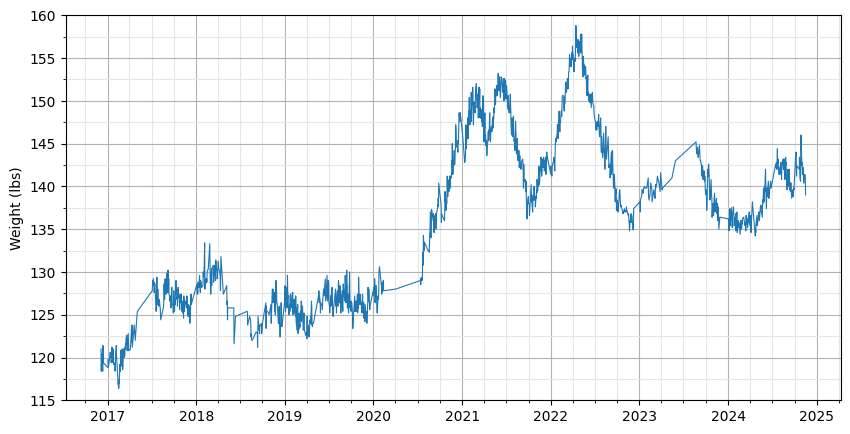

In [3]:
# Set a default style to use
plt.style.use('default')

# Generate the figure and axes. 
# This is a single set of axes in a figure with width 10 and height 5
fig, ax = plt.subplots(figsize = (10, 5))

# Generate the line plot
lines = ax.plot('Date', 'Weight', data = df_weight, lw = 0.80)

# This puts the grid below the data
ax.set_axisbelow(True)

# x-axis ticks
# x-axis tick locations
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval = 3))

# x-axis tick labels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# y-axis ticks
ax.set_yticks(np.arange(110, 160.1, 5))
ax.set_yticks(np.arange(110, 160.1, 2.5), minor = True)
ax.set_ylim(115, 160)

# Plot grids
ax.grid(visible = True, which = 'major', color = '0.7')
ax.grid(visible = True, which = 'minor', axis = 'both', color = '0.90')

# Axis labels
ax.set_ylabel("Weight (lbs)");

How do I aggregate data?

In [4]:
# Move index into column
df_weight['Date'] = df_weight.index

# Create a new column containing the starting day of the week
# How does this work? 
# df_weight['Date'].dt.dayofweek extracts the day of the week from the date object. Starts at 0 for Monday.
# Then pd.to_timedelta(unit = 'd') converts those values into TimeDeltas. So day of week 0 becomes a TimeDelta of 0.
# If the unit is something else, it converts the values into TimeDeltas at that unit. So unit = 'm' would 
# convert it into TimeDeltas of minutes. But it's just taking the values in the column. So those where 
# the day of week returned 1 would be converted into a TimeDelta of 1 minute. We want the TimeDeltas 
# to count days, so we use unit = 'd'.
# Then subtracting those TimeDeltas from the date values works to floor every date to the start of the
# week.
df_weight['WeekStart'] = df_weight['Date'] - pd.to_timedelta(df_weight['Date'].dt.dayofweek, unit = 'd')

# Calculate the weekly average
# The syntax here is different from R. 
# groupby specifies which column to group by
# But then we select the column to aggregate by, and chain it with a method
# The output is a Pandas Series, not a DataFrame
weight_weekly = df_weight.groupby('WeekStart')['Weight'].mean()

# Convert Series to DataFrame
df_weight_weekly = pd.DataFrame({'Date':weight_weekly.index, 'Weight':weight_weekly.values})

# Examine
df_weight_weekly.head()

,Date,Weight
0,2016-12-05,119.942857
1,2016-12-12,119.733333
2,2017-01-02,119.200000
3,2017-01-09,120.200000
4,2017-01-16,120.200000


In [5]:
# Today's date
today = datetime.date.today()

# Number of months past
nmonths = 6

# Get the date 6 months ago
six_months_ago = today - datetime.timedelta(days = 30*nmonths)

# Get entries after 6 months ago
weight_weekly_recent = weight_weekly.truncate(before = six_months_ago)

# Rebuild the weekly data frame
df_weight_weekly = pd.DataFrame({'Date':weight_weekly_recent.index,
                                 'Weight':weight_weekly_recent.values})

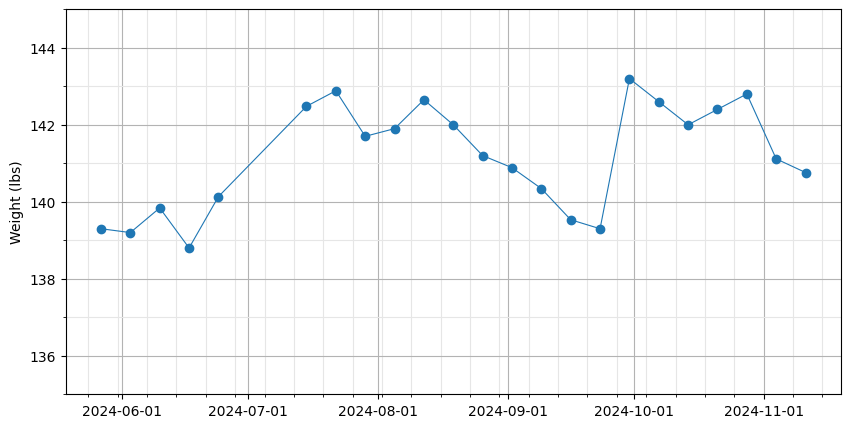

In [6]:
# Get min and max weights over the period
weight_min = min(df_weight_weekly['Weight'])
weight_max = max(df_weight_weekly['Weight'])

# Compute y-limits from min/max weights
ylim_min = math.floor(weight_min/5) * 5 
ylim_max = math.ceil(weight_max/5) * 5 

# Generate the figure and axes. 
# This is a single set of axes in a figure with width 10 and height 5
fig, ax = plt.subplots(figsize = (10, 5))

# Generate the line plot
lines = ax.plot('Date', 'Weight', data = df_weight_weekly, lw = 0.80)
points = ax.scatter('Date', 'Weight', data = df_weight_weekly)

# This puts the grid below the data
ax.set_axisbelow(True)

# x-axis ticks
# x-axis tick locations
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 1))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval = 7))

# x-axis tick labels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Set y-ticks and limits
ax.set_yticks(np.arange(110, 160.1, 2))
ax.set_yticks(np.arange(110, 160.1, 1), minor = True)
ax.set_ylim(ylim_min, ylim_max)

# Plot grids
ax.grid(visible = True, which = 'major', color = '0.7')
ax.grid(visible = True, which = 'minor', axis = 'both', color = '0.90')

ax.set_ylabel("Weight (lbs)");

There's data missing here that I need to figure out. I think I filtered it out with the import when I selected the Hevy data. 

Next is how do I compute the weekly deltas?

In [7]:
# Compute weight differences successive rows
df_weight_diff = df_weight_weekly.diff().rename(columns = {'Date':'Timelapse', 'Weight':'Difference'})

# Concatenate weight difference data to weight averages
df_weight_diff = pd.concat([df_weight_weekly, df_weight_diff], axis = 1)

# Remove first entry (which is NA)
df_weight_diff = df_weight_diff[1:]

df_weight_diff

,Date,Weight,Timelapse,Difference
1,2024-06-03,139.200000,7 days,-0.100000
2,2024-06-10,139.840000,7 days,0.640000
3,2024-06-17,138.800000,7 days,-1.040000
4,2024-06-24,140.133333,7 days,1.333333
5,2024-07-15,142.480000,21 days,2.346667
6,2024-07-22,142.883333,7 days,0.403333
7,2024-07-29,141.700000,7 days,-1.183333
8,2024-08-05,141.900000,7 days,0.200000
9,2024-08-12,142.650000,7 days,0.750000
10,2024-08-19,142.000000,7 days,-0.650000


In [8]:
# bar_colors = np.empty(len(df_weight_diff), dtype = "<U10")
# posdiff = df_weight_diff['Difference'] >= 0
# bar_colors[posdiff] = 'green'
# bar_colors[~posdiff] = 'red'

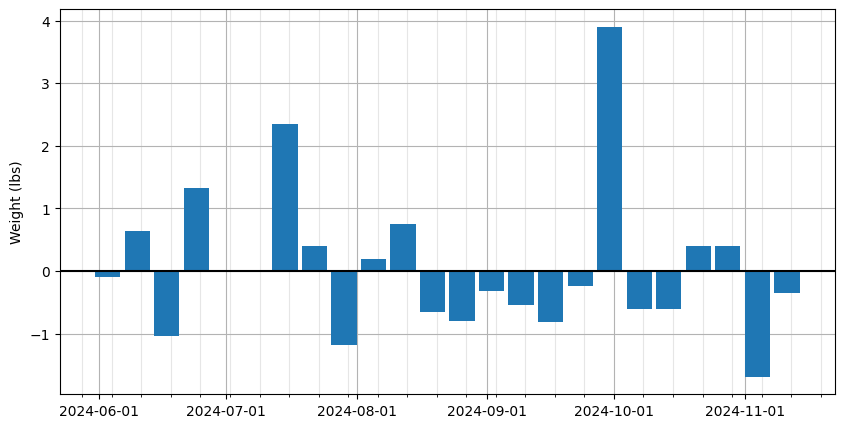

In [9]:
fig, ax = plt.subplots(figsize = (10, 5))

ax.bar('Date', 'Difference', 
       data = df_weight_diff,
       # color = bar_colors,
       align = 'center', 
       width = datetime.timedelta(days = 6))

# Horizontal line at y = 0
ax.axhline(y = 0, color = 'black')

# This puts the grid below the data
ax.set_axisbelow(True)

# x-axis ticks
# x-axis tick locations
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 1))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval = 7))

# x-axis tick labels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# ax.set_yticks(np.arange(-5, 6))
# ax.set_yticks(np.arange(-5, 6, 0.5), minor = True)

ax.grid(visible = True, which = 'major', color = '0.7')
ax.grid(visible = True, which = 'minor', axis = 'both', color = '0.90')

ax.set_ylabel('Weight (lbs)');

In [10]:
df_weight_diff.sort_values(by = 'Date').tail(n = 8)

,Date,Weight,Timelapse,Difference
15,2024-09-23,139.300000,7 days,-0.233333
16,2024-09-30,143.200000,7 days,3.900000
17,2024-10-07,142.600000,7 days,-0.600000
18,2024-10-14,142.000000,7 days,-0.600000
19,2024-10-21,142.400000,7 days,0.400000
20,2024-10-28,142.800000,7 days,0.400000
21,2024-11-04,141.114286,7 days,-1.685714
22,2024-11-11,140.760000,7 days,-0.354286
